In [1]:
# Always reload .py files
%load_ext autoreload
%autoreload 2

# Configuration
environment = 'local'


In [2]:
%% capture

# Install dependencies
if environment == 'local':
    %pip install -r ../requirements.txt
else:
    %pip install ipykernel kaggle matplotlib autopep8 pillow pandas numpy scipy urllib3 scikit-image --find-links https: // download.pytorch.org/whl/cu113/torch_stable.html torch == 1.11.0+cu113 torchaudio == 0.11.0+cu113 torchvision == 0.12.0+cu113 torch_tb_profiler tensorboard


UsageError: Cell magic `%%` not found.


In [3]:
if environment == 'colab':
    from google.colab import files
    import pathlib
    import os

    kaggle_path = '/root/.kaggle/kaggle.json'

    if not os.path.exists(kaggle_path):
        uploaded = files.upload()

        if not 'kaggle.json' in uploaded:
            raise Exception('Kaggle.json not found')

        pathlib.Path('/root/.kaggle').mkdir(exist_ok=True)
        os.rename('./kaggle.json', kaggle_path)

        !chmod 600 / root/.kaggle/kaggle.json

In [4]:
from dataset import MonetDataset, compute_stats, download_dataset
import torchvision
import torch



# Define custom paths
data_dir = os.path.join('..', 'data')

# Download the dataset
download_dataset(data_dir)

# Define preprocessing step
process = torchvision.transforms.ConvertImageDtype(torch.float)

# Load datasets
monet_dataset = MonetDataset(monet=True, data_dir=data_dir, transforms=process)
photo_dataset = MonetDataset(monet=False, data_dir=data_dir, transforms=process)

# Compute mean and std from the datasets
# imgnet_mean, imgnet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# monet_mean, monet_std = compute_stats(monet_dataset)
# photo_mean, photo_std = compute_stats(photo_dataset)

# Show stats
# print(f'Monet Mean: {monet_mean}, Monet STD: {monet_std}')
# print(f'Photo Mean: {photo_mean}, Photo STD: {photo_std}')
# print(f'ImageNet Mean: {imgnet_mean}, ImageNet STD: {imgnet_std}')


Dataset already exists at ..\data


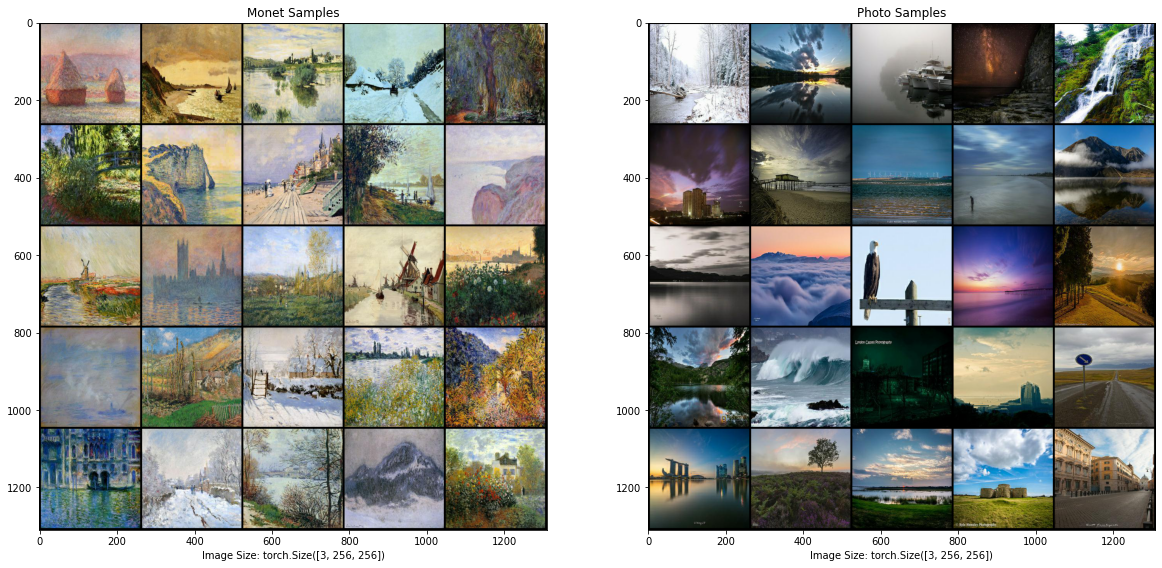

In [5]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Create a dataloader for previewing samples
batch_size = 25
row_count = int(np.sqrt(batch_size))
monet_preview_loader = DataLoader(monet_dataset, batch_size, shuffle=True)
photo_preview_loader = DataLoader(photo_dataset, batch_size, shuffle=True)

# Get a batch of images
monet_preview_imgs = next(iter(monet_preview_loader))
photo_preview_imgs = next(iter(photo_preview_loader))

# Make a grid (image) from a couple of samples from the training dataset
monet_preview_grid = make_grid(
    monet_preview_imgs, nrow=row_count, padding=5, normalize=True)
photo_preview_grid = make_grid(
    photo_preview_imgs, nrow=row_count, padding=5, normalize=True)

# Preview the samples
fig, (monet_axis, photo_axis) = plt.subplots(1, 2, figsize=(20, 20))
monet_axis.set_title('Monet Samples')
monet_axis.set_xlabel(f'Image Size: {monet_preview_imgs[0].size()}')
monet_axis.imshow(monet_preview_grid.permute(1, 2, 0))
photo_axis.set_title('Photo Samples')
photo_axis.set_xlabel(f'Image Size: {photo_preview_imgs[0].size()}')
photo_axis.imshow(photo_preview_grid.permute(1, 2, 0))
plt.show()


![DCGAN Generator](../resources/imgs/dcgan_generator.png)


In [6]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [7]:
from model import Discriminator, Generator
from torch import nn

# Customize network initialization
noise = 128

# Define GAN networks
D = Discriminator(in_chan=3, features=64, channels=1, bias=True, device=device, \
                  activ_fun=nn.LeakyReLU(inplace=True)) \
                 .to(device)
G = Generator(noise=noise, features=1024, channels=3, bias=False, device=device, \
              activ_fun=nn.ReLU(inplace=True))         \
             .to(device)

In [8]:
def preview_output(generator: nn.Module, noise: torch.Tensor, padding: int = 5):
    previous_mode: bool = generator.training
    generator.eval()

    with torch.no_grad():
        fake_imgs = generator(noise).cpu()
        nrows = int(torch.sqrt(torch.tensor(noise.size(0))).item())
        grid = make_grid(fake_imgs, nrow=nrows, padding=padding, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute((1, 2, 0)).numpy())
        plt.show()

    generator.train(previous_mode)

In [14]:
from torch.optim import Adam, SGD

# Initialize loss vectors
losses_D = []
losses_G = []

# Initialize probability vectors
prob_real = []
prob_fake = []
prob_fake_after_learn = []

# Customize training loop
epochs = 100
d_steps = 1

# Custom batch_size
batch_size = 4

# Create optimizers for each network
optim_G = Adam(G.parameters(), lr=1e-5)
optim_D = SGD(D.parameters(), lr=1e-5)

# Specify label types
fake_label = 0.
real_label = 1.

# Define loss function
loss_fn = torch.nn.BCELoss()

# Prepare dataloader
monet_dataset.transforms = torchvision.transforms.Compose([
    torchvision.transforms.ConvertImageDtype(dtype=torch.float),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
data_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Evaluate the same noise over time
fixed_noise = torch.randn((25, noise), device=device)
sample_freq = 3

# Train the DCGAN
for epoch in range(epochs):
    for batch_idx, real_img in enumerate(data_loader):
        # Get image sizes
        N, C, H, W = real_img.size()

        # --- Train the Discriminator ---
        for step in range(d_steps):
            # Reset gradients
            optim_D.zero_grad()

            # ^^^ Classify real images ^^^
            # Send data to GPU
            real_img = real_img.to(device)

            # Compute the output of the Discriminator for real images
            out_real = D(real_img).view(-1)
            labels = torch.full((N,), real_label, device=device, dtype=torch.float)
            loss_d_real = loss_fn(out_real, labels)
            prob_d_real = out_real.detach().mean().item()
        
            # Accumulate gradients
            loss_d_real.backward()

            # ^^^ Classify fake images ^^^
            noise_input = torch.randn((N, noise), device=device)
            fake_img = G(noise_input)

            # Compute the output of the Discriminator for fake images
            out_fake = D(fake_img.detach()).view(-1)
            labels.fill_(fake_label)
            loss_d_fake = loss_fn(out_fake, labels)
            prob_d_fake1 = out_fake.detach().mean().item()

            # Update the model
            loss_d_fake.backward()
            optim_D.step()

            # Retain the error
            loss_d = loss_d_real + loss_d_fake

        # --- Train the Generator ---
        # Reset gradients
        optim_G.zero_grad()

        # ^^^ Classify fake images ^^^
        noise_input = torch.randn((N, noise), device=device)
        fake_img = G(noise_input)

        # Compute the output of the Discriminator for fake images
        out_fake = D(fake_img).view(-1)
        labels.fill_(real_label)
        loss_g_fake = loss_fn(out_fake, labels)
        prob_d_fake2 = out_fake.detach().mean().item()

        # Update the model
        loss_g_fake.backward()
        optim_G.step()

        # Evaluate same noise output
        if (epoch + 1) % sample_freq == 0 and batch_idx == 0:
            preview_output(G, fixed_noise)

    print(f'Epoch {epoch}, D_prob_real={prob_d_real:.2}, D_prob_fake1={prob_d_fake1:.2},',
          f'D_prob_fake2={prob_d_fake2:.2}, D_loss={loss_d:.2}, G_loss={loss_g_fake:.2}')

    losses_D.append(loss_d.item())
    losses_G.append(loss_g_fake.item())
    prob_real.append(prob_d_real)
    prob_fake.append(prob_d_fake1)
    prob_fake_after_learn.append(prob_d_fake2)





tensor(-1.)
tensor(1.)


In [ ]:
G(fixed_noise).size()

In [ ]:
# Graph loss generator/discriminator
# Graph pt probabilitati ( real vs fake )
# Matrice de confuzie ( predictiile discriminatorului )
# Afisat norma ponderilor (weight_norm) - sa stim daca avem exploding weights
# Norma gradientilor (lungimea) - sa stim daca avem exploding gradients/vanishing gradients
# Paper - sa afisam activarile in spatiul intermediar (discriminator)


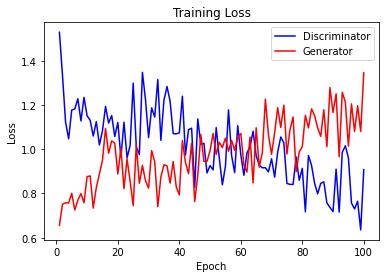

In [10]:

# Plot losses
def DGLoss(no_epochs, losses_D, losses_G):
        epochs = range(1, no_epochs+1)
        plt.plot(epochs, losses_D, 'b', label='Discriminator')
        plt.plot(epochs, losses_G, 'r', label='Generator')
        plt.legend()
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

DGLoss(epochs, losses_D, losses_G)

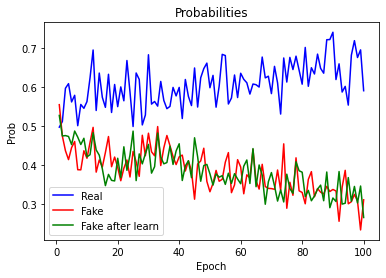

In [11]:
def DGProbs(no_epochs, prob_real, prob_fake1, prob_fake2):
        epochs = range(1, no_epochs+1)
        plt.plot(epochs, prob_real, 'b', label='Real')
        plt.plot(epochs, prob_fake1, 'r', label='Fake')
        plt.plot(epochs, prob_fake2, 'g', label='Fake after learn')
        plt.legend()
        plt.title('Probabilities')
        plt.xlabel('Epoch')
        plt.ylabel('Prob')
        plt.show()

DGProbs(epochs, prob_real, prob_fake, prob_fake_after_learn)